-	LAM (2015)
-	MONICA (2006)
-	INGRID (2005)
-	GEORGE (2007)
-	YASI (2011)
-	MARCIA (2015)
-	LAURENCE (2010)
-	LARRY (2006)

In [1]:
% pylab notebook
from datacube.storage import masking
import datacube 
from datetime import datetime
from skimage import exposure
import xarray as xr
import cartopy.crs as ccrs
from datacube.helpers import ga_pq_fuser
import os

#dcman = datacube.Datacube(config='/home/156/cek156/mangroves.conf')
dc = datacube.Datacube(app='mangrove')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def write_your_netcdf(data, dataset_name, filename, metadata):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = metadata.crs.crs_str
    dataset.attrs['affine'] = metadata.affine
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        dataset.to_netcdf(filename, 'w')
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))

In [3]:
storm = 'GEORGE'

# Load in the windfield dataset

In [4]:
wind = xr.open_dataset('/g/data/r78/mangroves/{0}/windfield/gust.001-00001.nc'.format(storm))

## Use the map widgets to zoom the map into the required extent

**Note: Try to limit the extent as much as possible to avoid memory errors!**

<IPython.core.display.Javascript object>


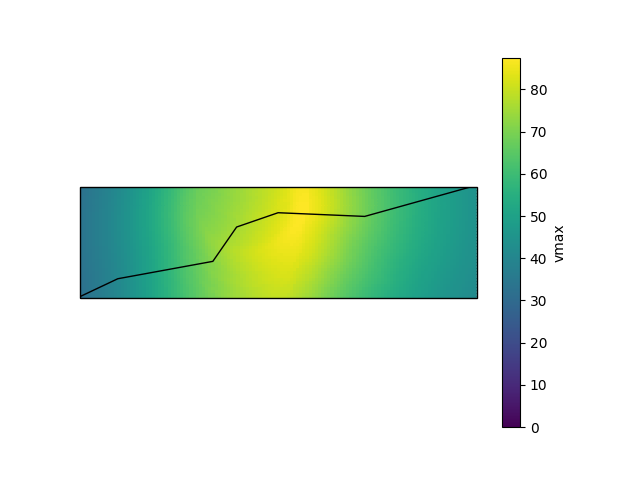

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


In [5]:
fig, axes = plt.subplots()
ax = plt.subplot(projection=ccrs.PlateCarree())
wind.vmax.plot.pcolormesh(ax=ax, infer_intervals=True)
ax.coastlines()

# Grab land sea mask for the area of interest

For the purposes of this study, we can just grab the land/sea mask that is provided with the Landsat data. Note that this may not be 100% correct, however given that we are simply using it to develop a generic land surface roughness dataset, this should have minimal effect on the final result.

In [6]:
lon1, lon2, lat1, lat2 = ax.get_extent()

query = {
        'lat': (lat1, lat2),
        'lon': (lon1, lon2),
        'time':('2015-06-01', '2015-06-30')
        }

data = dc.load(product='ls8_pq_albers', group_by='solar_day', **query)

In [7]:
mask_components = {'land_sea' : 'land'}
landsea_mask = masking.make_mask(data, **mask_components)

## Check the mask looks ok

In [8]:
landsea_mask

<xarray.Dataset>
Dimensions:       (time: 5, x: 10803, y: 4206)
Coordinates:
  * x             (x) float64 -1.459e+06 -1.459e+06 -1.459e+06 -1.459e+06 ...
  * time          (time) datetime64[ns] 2015-06-06T02:01:03.500000 ...
  * y             (y) float64 -2.174e+06 -2.174e+06 -2.174e+06 -2.174e+06 ...
Data variables:
    pixelquality  (time, y, x) bool False False False False False False ...
Attributes:
    crs:      EPSG:3577

<IPython.core.display.Javascript object>


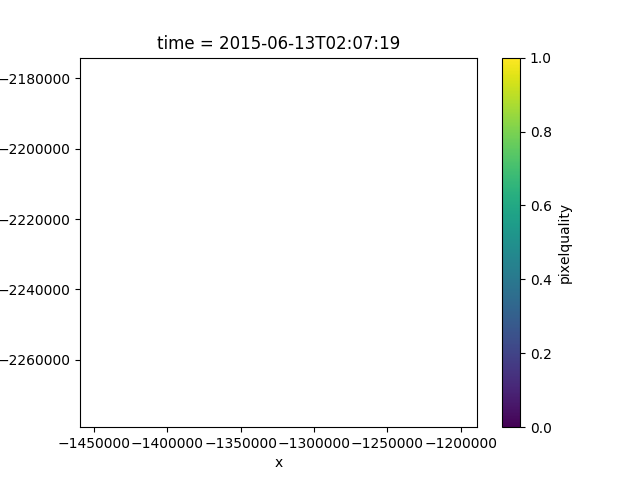

In [13]:
fig, axes = plt.subplots()
landsea_mask.pixelquality.isel(time = 1).plot()

In [31]:
okTimeStep = 2

# Now we need to create our land cover mask

We will be using a very rough estimate on landcover, focussing on vegetation that exists along the coastline, within the mangrove extent.

Surface roughness estimates can be found in the Australian/New Zealand building Standard AS/NZS 1170.2 Supp 1, 2002. Structural design actions-Wind actions-Commentary. Values relevant from this standard were extracted for inclusion in the GA Publication [Local Wind Assessment in Australia, Computation Methodology for Wind Multipliers](http://pid.geoscience.gov.au/dataset/75299
), produced in 2014. This publication outlines the processes for calculating wind multipliers (which is ultimately what this landcover product is feeding in to). 

This publication highlights the following landcover types, and their associated surface roughness values:

|Terrain classes |Terrain roughness length (m) |Terrain category|
|----------------|-----------------------------|----------------|
|City buildings| 2 |4.00|
|Forest |1 |3.70|
|High density (industrial) buildings |0.8 |3.60|
|Small town centres |0.4 |3.30|
|Suburban/wooded country |0.2 |3.00|
|Orchard, open forest| 0.08 |2.60|
|Long grass with few trees |0.06 |2.48|
|Crops |0.04 |2.30|
|Open rough water, airfields, uncut grass etc. |0.02 |2.00|
|Cut grass |0.008| 1.60|
|Desert (stones), roads |0.006 |1.48|
|Mudflats/salt evaporators/sandy beaches |0.004 |1.30|
|Snow surface |0.002 |1.00|

We will pick a mid-range surface roughness value of **0.2** to assign to all land values

In [32]:
landcover = landsea_mask * 0.2 # sneaky trick to convert boolean to 0 /1 
newName = {'pixelquality':'surfaceRoughness'}
landcover.rename(newName, inplace = True)
landcover = landcover.isel(time = okTimeStep).drop('time')

In [ ]:
fig, axes = plt.subplots()
landcover.surfaceRoughness.plot()

In [33]:
write_your_netcdf(landcover, 'surfaceRoughness', 
                  '/g/data/r78/mangroves/{0}/windfield/{0}_localWindfield_Landfall1b.nc'.format(storm), data)